In [ ]:
!pip install pyspark

In [ ]:
# Imports
### Code by Chandramani
import os
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.sql import functions as f
from pyspark.sql.functions import udf, StringType, col, when, max, rand, hour, minute, expr, min
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer
from functools import reduce

In [ ]:
spark = SparkSession.builder.getOrCreate()

In [ ]:

rdd_accidents = spark.read.load("/content/drive/MyDrive/Machine Learning/651/Project/accidents.parquet")

#Uncomment to select subset of the data
######################## UNCOMMENT FOR TESTING ##########################
#rdd_accidents = rdd_accidents.sample(withReplacement=False, fraction=0.1)
#########################################################################

rdd_accidents.head()

Row(Accident_Index='200906P015939', 1st_Road_Class='B', 1st_Road_Number='6222', 2nd_Road_Class='C', 2nd_Road_Number='0', Accident_Severity='Slight', Carriageway_Hazards='None', Date=datetime.date(2009, 5, 19), Day_of_Week='Tuesday', Did_Police_Officer_Attend_Scene_of_Accident='1', Junction_Control='Give way or uncontrolled', Junction_Detail='T or staggered junction', Latitude=53.604703, Light_Conditions='Daylight', Local_Authority_District='Rochdale', Local_Authority_Highway='Rochdale', Location_Easting_OSGR=385210, Location_Northing_OSGR=412040, Longitude=-2.224994, LSOA_of_Accident_Location='E01005499', Number_of_Casualties=1, Number_of_Vehicles=3, Pedestrian_Crossing_Human_Control='0', Pedestrian_Crossing_Physical_Facilities='0', Police_Force='Greater Manchester', Road_Surface_Conditions='Wet or damp', Road_Type='Single carriageway', Special_Conditions_at_Site='None', Speed_limit=40, Time=datetime.datetime(2023, 11, 27, 12, 50), Urban_or_Rural_Area='Rural', Weather_Conditions='Fine 

In [ ]:
#rename columns with special characters
rdd_accidents = rdd_accidents.withColumnRenamed("Local_Authority_(District)", "Local_Authority_District")\
    .withColumnRenamed("Local_Authority_(Highway)", "Local_Authority_Highway")\
    .withColumnRenamed("Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing_Human_Control")\
    .withColumnRenamed("Pedestrian_Crossing-Physical_Facilities", "Pedestrian_Crossing_Physical_Facilities")
#create Hour column
#rdd_accidents = rdd_accidents.withColumn("Hour", rdd_accidents["Time"].substr(0, 2).cast("int"))

rdd_accidents.createOrReplaceTempView("accidents")
rdd_accidents.printSchema()
print("number of records: {:d}".format(rdd_accidents.count()))

root
 |-- Accident_Index: string (nullable = true)
 |-- 1st_Road_Class: string (nullable = true)
 |-- 1st_Road_Number: string (nullable = true)
 |-- 2nd_Road_Class: string (nullable = true)
 |-- 2nd_Road_Number: string (nullable = true)
 |-- Accident_Severity: string (nullable = true)
 |-- Carriageway_Hazards: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- Did_Police_Officer_Attend_Scene_of_Accident: string (nullable = true)
 |-- Junction_Control: string (nullable = true)
 |-- Junction_Detail: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Light_Conditions: string (nullable = true)
 |-- Local_Authority_District: string (nullable = true)
 |-- Local_Authority_Highway: string (nullable = true)
 |-- Location_Easting_OSGR: integer (nullable = true)
 |-- Location_Northing_OSGR: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- LSOA_of_Accident_Location: string (nullable = true)
 |-- Numbe

In [ ]:
import random as rnd
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')
cmap=plt.get_cmap('Pastel2')
#cmap=plt.get_cmap('tab20c')

mypath_ = !pwd

def save_fig(fig_id, fig_txt, tight_layout=True, fig_extension="png", resolution=300):
    #generic function to save images to file
    filename =  '/content/drive/MyDrive/Machine Learning/651/Project/' + fig_txt + "." + fig_extension
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    fig_id.savefig(filename, format=fig_extension, dpi=resolution, bbox_inches='tight')
    file_data=open(filename, 'rb')
    #project.save_data(data=file_data.read(),file_name=fig_txt+'.png',overwrite=True)
    file_data.close()

<ipython-input-55-e151c51e491b>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


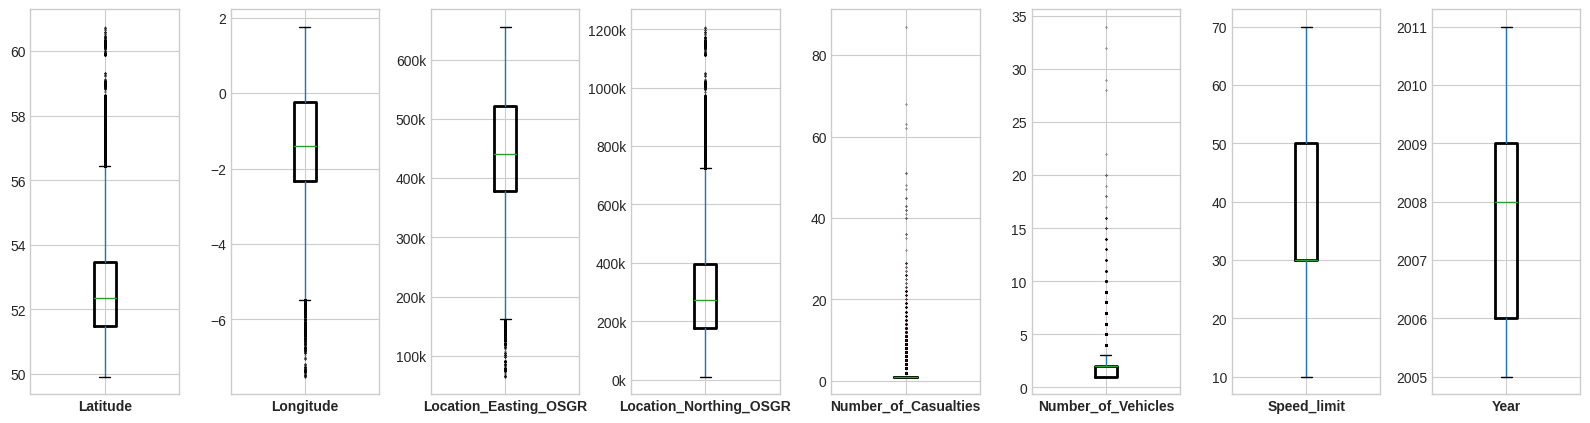

In [ ]:
numerical_feat =[
'Latitude',
'Longitude',
'Location_Easting_OSGR',
'Location_Northing_OSGR',
'Number_of_Casualties',
'Number_of_Vehicles',
'Speed_limit',
'Year']
sql_query= '''SELECT {} FROM {}'''
rdd_num_cols = spark.sql(sql_query.format(', '.join(numerical_feat), "accidents")).toPandas()

fig, axes = plt.subplots(nrows=1, ncols=len(numerical_feat), figsize=(20,5))
mkr = dict(markerfacecolor='r', markeredgecolor=None,  marker='.', markersize=0.5)
for i,col in enumerate(numerical_feat):
    rdd_num_cols.boxplot(column=col, ax=axes[i], flierprops=mkr, boxprops= dict(linewidth=2.0))
    axes[i].set_xticklabels(labels=axes[i].get_xticklabels(), fontweight='bold')
axes[2].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}k".format(x/1000)))
axes[3].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}k".format(x/1000)))
plt.subplots_adjust(wspace=0.35)

###Check that LSOA data is consistent with GPS Coordinates

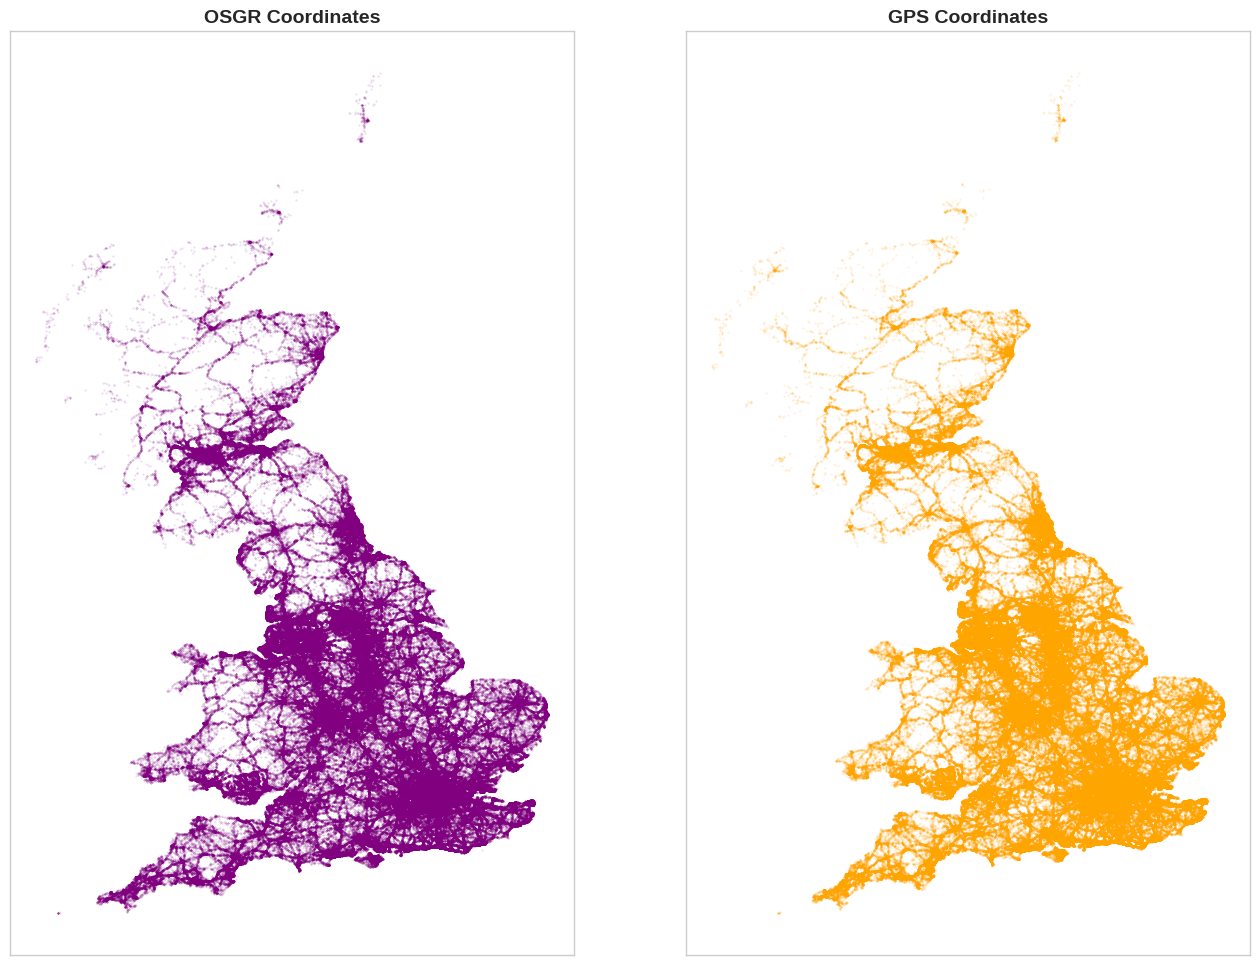

In [ ]:

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,12))
ax1.scatter(rdd_num_cols.Location_Easting_OSGR,rdd_num_cols.Location_Northing_OSGR, marker='.', alpha=0.2, s=0.5, c='purple')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("OSGR Coordinates", fontweight='bold', fontsize=14)
ax2.scatter(rdd_num_cols.Longitude,rdd_num_cols.Latitude, marker='.', alpha=0.2, s=0.5, c='orange')
ax2.set_xticks([])
ax2.set_yticks([])
t=ax2.set_title("GPS Coordinates", fontweight='bold', fontsize=14)


In [ ]:
# Accident_Index, Date and LSOA_of_Accident_Location excluded
cat_cols1=[
 'Accident_Severity',
 'Day_of_Week',
 'Urban_or_Rural_Area']
cat_cols2=[
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Light_Conditions',
 'Special_Conditions_at_Site']
cat_cols3=[
 '1st_Road_Class',
 '2nd_Road_Class',
 'Road_Type',
 'Carriageway_Hazards']
cat_cols4=[
 'Junction_Control',
 'Junction_Detail',
 'Pedestrian_Crossing_Human_Control',
 'Pedestrian_Crossing_Physical_Facilities']
cat_cols5=[
 'Did_Police_Officer_Attend_Scene_of_Accident',
 'InScotland']

In [ ]:
#del rdd_num_cols
cat_cols = cat_cols1+cat_cols2+cat_cols3+cat_cols4+cat_cols5
cat_labels={}
for col in cat_cols:
    sql_query= '''SELECT {}, COUNT({})* 100.0 / (select count(*) from {}) AS Pct FROM {} GROUP BY {}'''
    rdd_cat= spark.sql(sql_query.format(col, col,"accidents", "accidents",col)).toPandas()
    rdd_cat['Pct'] = rdd_cat['Pct'].map('{:,.1f}'.format)
    cat_labels[col] = list(rdd_cat[col].values)
    display(rdd_cat)

,Accident_Severity,Pct
0,Slight,85.4
1,Fatal,1.4
2,Serious,13.2


,Day_of_Week,Pct
0,Wednesday,15.1
1,Tuesday,14.9
2,Friday,16.4
3,Thursday,14.9
4,Saturday,13.5
5,Monday,14.2
6,Sunday,11.0


,Urban_or_Rural_Area,Pct
0,Urban,64.0
1,Rural,36.0
2,Unallocated,0.0


,Weather_Conditions,Pct
0,Raining + high winds,1.4
1,Snowing no high winds,0.8
2,Unknown,2.0
3,Other,2.4
4,Fine no high winds,79.7
5,Snowing + high winds,0.1
6,Raining no high winds,11.7
7,Data missing or out of range,0.0
8,Fog or mist,0.6
9,Fine + high winds,1.3


,Road_Surface_Conditions,Pct
0,Wet or damp,28.3
1,Dry,68.6
2,Flood over 3cm. deep,0.1
3,Frost or ice,2.2
4,Snow,0.7
5,Data missing or out of range,0.1


,Light_Conditions,Pct
0,Darkness - lights unlit,0.4
1,Darkness - lighting unknown,0.9
2,Daylight,73.2
3,Darkness - lights lit,19.8
4,Darkness - no lighting,5.7


,Special_Conditions_at_Site,Pct
0,Mud,0.3
1,None,97.4
2,Roadworks,1.2
3,Oil or diesel,0.4
4,Auto signal part defective,0.1
5,Road surface defective,0.2
6,Auto traffic signal - out,0.2
7,Data missing or out of range,0.0
8,Road sign or marking defective or obscured,0.2


,1st_Road_Class,Pct
0,A(M),0.3
1,Motorway,4.0
2,B,12.7
3,C,9.0
4,A,45.1
5,Unclassified,29.0


,2nd_Road_Class,Pct
0,A(M),0.1
1,Motorway,0.7
2,NA,41.7
3,B,3.9
4,C,4.6
5,A,9.8
6,Unclassified,39.3


,Road_Type,Pct
0,Slip road,1.1
1,One way street,2.1
2,Unknown,0.7
3,Roundabout,6.6
4,Single carriageway,74.5
5,Dual carriageway,15.0


,Carriageway_Hazards,Pct
0,None,98.1
1,Previous accident,0.2
2,Other object on road,0.8
3,Vehicle load on road,0.1
4,Pedestrian in carriageway - not injured,0.2
5,Any animal in carriageway (except ridden horse),0.5
6,Data missing or out of range,0.0


,Junction_Control,Pct
0,Stop sign,0.7
1,Give way or uncontrolled,48.2
2,Authorised person,0.2
3,Data missing or out of range,34.3
4,Auto traffic signal,10.2
5,Not at junction or within 20 metres,6.5


,Junction_Detail,Pct
0,Other junction,3.2
1,Mini-roundabout,1.0
2,T or staggered junction,30.7
3,Slip road,1.5
4,Roundabout,8.5
5,More than 4 arms (not roundabout),1.5
6,Private drive or entrance,3.6
7,Crossroads,9.5
8,Not at junction or within 20 metres,40.6
9,Data missing or out of range,0.0


,Pedestrian_Crossing_Human_Control,Pct
0,0,99.4
1,1,0.2
2,2,0.4
3,NA,0.0


,Pedestrian_Crossing_Physical_Facilities,Pct
0,7,0.3
1,8,1.7
2,0,84.2
3,5,6.3
4,1,2.5
5,4,5.1
6,NA,0.0


,Did_Police_Officer_Attend_Scene_of_Accident,Pct
0,3,0.3
1,NA,0.0
2,1,80.5
3,2,19.2


,InScotland,Pct
0,No,93.9
1,Yes,6.1
2,NA,0.0


Some categorical variables have missing data ('Unallocated', 'Data missing or out of range' or 'NA')
We simply remove the missing data when it represents less than 1% of total number of records
The 41% of NA values for '2nd_Road_Class' corresponds to the 40% of accidents not occuring at a Junction (so on a single road)

In [ ]:
def unselect_row(cols, cond, df_view):
    for col in cols:
        sql_query = '''SELECT * FROM {} WHERE {} != {}'''
        rdd_new = spark.sql(sql_query.format(df_view, col, "'"+cond+"'"))
        rdd_new.createOrReplaceTempView(df_view)
    return rdd_new


#Delete 'Unallocated' from
cols=['Urban_or_Rural_Area']
rdd_accidents = unselect_row(cols, 'Unallocated', "accidents")

#Delete all 'Data missing or out of range' from:
cols=['Weather_Conditions',
'Road_Surface_Conditions',
'Light_Conditions',
'Special_Conditions_at_Site',
'Road_Type',
'Carriageway_Hazards',
'Junction_Detail']
rdd_accidents = unselect_row(cols, 'Data missing or out of range', "accidents")

#delete all 'NA' from:
cols = ['Pedestrian_Crossing_Human_Control',
'Pedestrian_Crossing_Physical_Facilities',
'Did_Police_Officer_Attend_Scene_of_Accident',
'InScotland']
rdd_accidents = unselect_row(cols, 'NA', "accidents")

cat_cols = cat_cols1+cat_cols2+cat_cols3+cat_cols4+cat_cols5
cat_labels={}
for col in cat_cols:
    sql_query= '''SELECT {}, COUNT({})* 100.0 / (SELECT COUNT(*) FROM {}) AS Pct FROM {} GROUP BY {}'''
    rdd_cat= spark.sql(sql_query.format(col, col,"accidents", "accidents",col)).toPandas()
    rdd_cat['Pct'] = rdd_cat['Pct'].map('{:,.1f}'.format)
    cat_labels[col] = list(rdd_cat[col].values)
    display(rdd_cat)

,Accident_Severity,Pct
0,Slight,85.4
1,Fatal,1.4
2,Serious,13.3


,Day_of_Week,Pct
0,Wednesday,15.1
1,Tuesday,14.9
2,Friday,16.4
3,Thursday,14.9
4,Saturday,13.5
5,Monday,14.2
6,Sunday,11.0


,Urban_or_Rural_Area,Pct
0,Urban,64.0
1,Rural,36.0


,Weather_Conditions,Pct
0,Raining + high winds,1.4
1,Snowing no high winds,0.8
2,Unknown,1.9
3,Other,2.4
4,Fine no high winds,79.8
5,Snowing + high winds,0.1
6,Raining no high winds,11.8
7,Fog or mist,0.6
8,Fine + high winds,1.3


,Road_Surface_Conditions,Pct
0,Wet or damp,28.3
1,Dry,68.6
2,Flood over 3cm. deep,0.1
3,Frost or ice,2.2
4,Snow,0.7


,Light_Conditions,Pct
0,Darkness - lights unlit,0.4
1,Darkness - lighting unknown,0.9
2,Daylight,73.2
3,Darkness - lights lit,19.8
4,Darkness - no lighting,5.7


,Special_Conditions_at_Site,Pct
0,Mud,0.3
1,None,97.5
2,Roadworks,1.2
3,Oil or diesel,0.4
4,Auto signal part defective,0.1
5,Road surface defective,0.2
6,Auto traffic signal - out,0.2
7,Road sign or marking defective or obscured,0.2


,1st_Road_Class,Pct
0,A(M),0.3
1,Motorway,4.0
2,B,12.7
3,C,9.0
4,A,45.1
5,Unclassified,28.9


,2nd_Road_Class,Pct
0,A(M),0.1
1,Motorway,0.7
2,NA,41.6
3,B,3.9
4,C,4.6
5,A,9.8
6,Unclassified,39.3


,Road_Type,Pct
0,Slip road,1.1
1,One way street,2.1
2,Unknown,0.7
3,Roundabout,6.6
4,Single carriageway,74.5
5,Dual carriageway,15.0


,Carriageway_Hazards,Pct
0,None,98.1
1,Previous accident,0.2
2,Other object on road,0.8
3,Vehicle load on road,0.1
4,Pedestrian in carriageway - not injured,0.2
5,Any animal in carriageway (except ridden horse),0.5


,Junction_Control,Pct
0,Stop sign,0.7
1,Give way or uncontrolled,48.2
2,Authorised person,0.2
3,Data missing or out of range,34.3
4,Auto traffic signal,10.2
5,Not at junction or within 20 metres,6.5


,Junction_Detail,Pct
0,Other junction,3.2
1,Mini-roundabout,1.0
2,T or staggered junction,30.7
3,Slip road,1.5
4,Roundabout,8.5
5,More than 4 arms (not roundabout),1.5
6,Private drive or entrance,3.6
7,Crossroads,9.5
8,Not at junction or within 20 metres,40.6


,Pedestrian_Crossing_Human_Control,Pct
0,0,99.4
1,1,0.2
2,2,0.4


,Pedestrian_Crossing_Physical_Facilities,Pct
0,7,0.3
1,8,1.7
2,0,84.2
3,5,6.3
4,1,2.5
5,4,5.1


,Did_Police_Officer_Attend_Scene_of_Accident,Pct
0,3,0.2
1,1,80.6
2,2,19.2


,InScotland,Pct
0,No,93.9
1,Yes,6.1


# Feature Engineering

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *
import datetime

def date_to_week(date_str):
    date_str = str(date_str)
    return datetime.datetime.strptime(date_str,'%Y-%m-%d').date().isocalendar()[1]

udf_date_to_week = udf(date_to_week, IntegerType())
rdd_accidents = rdd_accidents.withColumn("Week", udf_date_to_week("Date"))

rdd_accidents.head()

Row(Accident_Index='200906P015939', 1st_Road_Class='B', 1st_Road_Number='6222', 2nd_Road_Class='C', 2nd_Road_Number='0', Accident_Severity='Slight', Carriageway_Hazards='None', Date=datetime.date(2009, 5, 19), Day_of_Week='Tuesday', Did_Police_Officer_Attend_Scene_of_Accident='1', Junction_Control='Give way or uncontrolled', Junction_Detail='T or staggered junction', Latitude=53.604703, Light_Conditions='Daylight', Local_Authority_District='Rochdale', Local_Authority_Highway='Rochdale', Location_Easting_OSGR=385210, Location_Northing_OSGR=412040, Longitude=-2.224994, LSOA_of_Accident_Location='E01005499', Number_of_Casualties=1, Number_of_Vehicles=3, Pedestrian_Crossing_Human_Control='0', Pedestrian_Crossing_Physical_Facilities='0', Police_Force='Greater Manchester', Road_Surface_Conditions='Wet or damp', Road_Type='Single carriageway', Special_Conditions_at_Site='None', Speed_limit=40, Time=datetime.datetime(2023, 11, 27, 12, 50), Urban_or_Rural_Area='Rural', Weather_Conditions='Fine 

In [ ]:


# Define a function to extract the hour from the Time column with null check
def extract_hour(time):
    return time.hour if time is not None else 12

# Create a user-defined function (UDF) for extracting the hour
udf_extract_hour = udf(extract_hour, IntegerType())

# Add the Hour column to the DataFrame
rdd_accidents = rdd_accidents.withColumn("Hour", udf_extract_hour("Time"))

# Display the updated DataFrame
rdd_accidents.head()

Row(Accident_Index='200906P015939', 1st_Road_Class='B', 1st_Road_Number='6222', 2nd_Road_Class='C', 2nd_Road_Number='0', Accident_Severity='Slight', Carriageway_Hazards='None', Date=datetime.date(2009, 5, 19), Day_of_Week='Tuesday', Did_Police_Officer_Attend_Scene_of_Accident='1', Junction_Control='Give way or uncontrolled', Junction_Detail='T or staggered junction', Latitude=53.604703, Light_Conditions='Daylight', Local_Authority_District='Rochdale', Local_Authority_Highway='Rochdale', Location_Easting_OSGR=385210, Location_Northing_OSGR=412040, Longitude=-2.224994, LSOA_of_Accident_Location='E01005499', Number_of_Casualties=1, Number_of_Vehicles=3, Pedestrian_Crossing_Human_Control='0', Pedestrian_Crossing_Physical_Facilities='0', Police_Force='Greater Manchester', Road_Surface_Conditions='Wet or damp', Road_Type='Single carriageway', Special_Conditions_at_Site='None', Speed_limit=40, Time=datetime.datetime(2023, 11, 27, 12, 50), Urban_or_Rural_Area='Rural', Weather_Conditions='Fine 

DataFrame[Week: int, slight: bigint, severe: bigint]

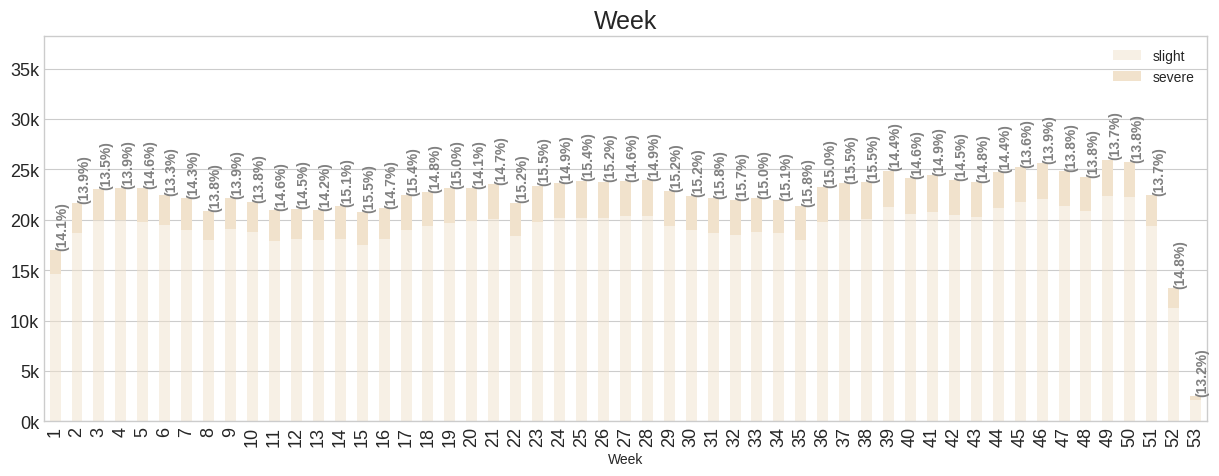

In [ ]:
def plot_ord_feature(df_view, col, ax=None, bar_color=cmap(6)):
    severe_col = "Accident_Severity"
    acc_type = "Slight"
    sql_query = '''
    SELECT
        {},
        COUNT(CASE WHEN {}  = '{}' THEN {} END) AS slight,
        COUNT(CASE WHEN {} != '{}' THEN {} END) AS severe
    FROM {} GROUP BY {}'''
    rdd_col = spark.sql(sql_query.format(col, severe_col, acc_type, col,severe_col, acc_type, col, df_view, col))
    df_plot = rdd_col.toPandas().dropna().sort_values(by=[col])
    clrmap = [(bar_color[0],bar_color[1],bar_color[2],bar_color[3]*0.5), bar_color]
    ax = df_plot.plot(col, kind='bar', ax=ax, fontsize=13, title=col.replace('_', ' '),
                      color=clrmap, stacked=True)
    #ax = plt.gca()
    ax.set_ylabel('')
    ax.set_alpha(0.8)
    ax.xaxis.grid(False)
    ax.set_xticklabels(df_plot[col])
    ax.title.set_size(18)
    for idx, label in enumerate(list(df_plot.index)):
        total = df_plot.loc[label]['slight']+df_plot.loc[label]['severe']
        value = "({}%)".format(np.round(100*df_plot.loc[label]['severe']/(total),decimals=1))
        ax.annotate(value, (idx, total), xytext=(0, 0), textcoords='offset points',
                   fontsize=10, color='grey', fontweight='bold', rotation=90, va ='bottom')

    #ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:0}".format(x)))
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}k".format(int(x/1000))))
    left, right = ax.get_ylim()  # return the current xlim
    ax.set_ylim((left, right*1.4))
    return rdd_col

rdd_accidents.createOrReplaceTempView("accidents")
fig, ax = plt.subplots(figsize=(15,5))
plot_ord_feature("accidents", "Week", ax=ax)

## Change FATAL into Serious

In [ ]:
def aggregate_features(feature, from_value_list, to_value, rdd_df, df_view):

    def change_feature(from_value_str):
        return to_value if from_value_str in from_value_list else from_value_str

    udf_change = udf(change_feature, StringType())
    rdd_new = rdd_df.withColumn(feature, udf_change(feature))
    rdd_new.createOrReplaceTempView(df_view)
    return rdd_new


#def fatal_to_serious(severity_str):
#    return 'Serious' if severity_str=='Fatal' else severity_str

#udf_fatal_to_serious = udf(fatal_to_serious, StringType())
#rdd_accidents = rdd_accidents.withColumn("Accident_Severity", udf_fatal_to_serious("Accident_Severity"))

rdd_accidents = aggregate_features("Accident_Severity", ['Fatal'], 'Serious', rdd_accidents, "accidents")

rdd_accidents.head()
#rdd_accidents.createOrReplaceTempView("accidents")

Row(Accident_Index='200906P015939', 1st_Road_Class='B', 1st_Road_Number='6222', 2nd_Road_Class='C', 2nd_Road_Number='0', Accident_Severity='Slight', Carriageway_Hazards='None', Date=datetime.date(2009, 5, 19), Day_of_Week='Tuesday', Did_Police_Officer_Attend_Scene_of_Accident='1', Junction_Control='Give way or uncontrolled', Junction_Detail='T or staggered junction', Latitude=53.604703, Light_Conditions='Daylight', Local_Authority_District='Rochdale', Local_Authority_Highway='Rochdale', Location_Easting_OSGR=385210, Location_Northing_OSGR=412040, Longitude=-2.224994, LSOA_of_Accident_Location='E01005499', Number_of_Casualties=1, Number_of_Vehicles=3, Pedestrian_Crossing_Human_Control='0', Pedestrian_Crossing_Physical_Facilities='0', Police_Force='Greater Manchester', Road_Surface_Conditions='Wet or damp', Road_Type='Single carriageway', Special_Conditions_at_Site='None', Speed_limit=40, Time=datetime.datetime(2023, 11, 27, 12, 50), Urban_or_Rural_Area='Rural', Weather_Conditions='Fine 

In [ ]:
## Simplify weather conditions
#<b>Weather_Conditions	Pct
feature = 'Weather_Conditions'
from_value_list=  ['Unknown', 'Other']
to_value = 'Other'
rdd_accidents = aggregate_features(feature, from_value_list, to_value, rdd_accidents, "accidents")

rdd_accidents.head()

Row(Accident_Index='200906P015939', 1st_Road_Class='B', 1st_Road_Number='6222', 2nd_Road_Class='C', 2nd_Road_Number='0', Accident_Severity='Slight', Carriageway_Hazards='None', Date=datetime.date(2009, 5, 19), Day_of_Week='Tuesday', Did_Police_Officer_Attend_Scene_of_Accident='1', Junction_Control='Give way or uncontrolled', Junction_Detail='T or staggered junction', Latitude=53.604703, Light_Conditions='Daylight', Local_Authority_District='Rochdale', Local_Authority_Highway='Rochdale', Location_Easting_OSGR=385210, Location_Northing_OSGR=412040, Longitude=-2.224994, LSOA_of_Accident_Location='E01005499', Number_of_Casualties=1, Number_of_Vehicles=3, Pedestrian_Crossing_Human_Control='0', Pedestrian_Crossing_Physical_Facilities='0', Police_Force='Greater Manchester', Road_Surface_Conditions='Wet or damp', Road_Type='Single carriageway', Special_Conditions_at_Site='None', Speed_limit=40, Time=datetime.datetime(2023, 11, 27, 12, 50), Urban_or_Rural_Area='Rural', Weather_Conditions='Fine 

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

def hour_to_peak(hour):
    try:
        return 'Peak' if (hour>=8 and hour<=18) else 'OffPeak'
    except:
        return ''

udf_hour_to_peak = udf(hour_to_peak, StringType())
rdd_accidents = rdd_accidents.withColumn("Peak_or_OffPeak", udf_hour_to_peak("Hour"))

rdd_accidents.head()

Row(Accident_Index='200906P015939', 1st_Road_Class='B', 1st_Road_Number='6222', 2nd_Road_Class='C', 2nd_Road_Number='0', Accident_Severity='Slight', Carriageway_Hazards='None', Date=datetime.date(2009, 5, 19), Day_of_Week='Tuesday', Did_Police_Officer_Attend_Scene_of_Accident='1', Junction_Control='Give way or uncontrolled', Junction_Detail='T or staggered junction', Latitude=53.604703, Light_Conditions='Daylight', Local_Authority_District='Rochdale', Local_Authority_Highway='Rochdale', Location_Easting_OSGR=385210, Location_Northing_OSGR=412040, Longitude=-2.224994, LSOA_of_Accident_Location='E01005499', Number_of_Casualties=1, Number_of_Vehicles=3, Pedestrian_Crossing_Human_Control='0', Pedestrian_Crossing_Physical_Facilities='0', Police_Force='Greater Manchester', Road_Surface_Conditions='Wet or damp', Road_Type='Single carriageway', Special_Conditions_at_Site='None', Speed_limit=40, Time=datetime.datetime(2023, 11, 27, 12, 50), Urban_or_Rural_Area='Rural', Weather_Conditions='Fine 

In [ ]:
#create centroid dataset
sql_query = '''
    SELECT
    LSOA_of_Accident_Location,
    PERCENTILE(Latitude, 0.5) AS Centroid_Latitude,
    PERCENTILE(Longitude, 0.5) AS Centroid_Longitude
    FROM accidents
    GROUP BY LSOA_of_Accident_Location'''
lsoa_data = spark.sql(sql_query)
#merge with main datset - remove duplicated column
rdd_accidents = rdd_accidents.join(lsoa_data, rdd_accidents.LSOA_of_Accident_Location == lsoa_data.LSOA_of_Accident_Location)\
    .drop(lsoa_data.LSOA_of_Accident_Location)
rdd_accidents.take(1)

[Row(Accident_Index='200906P015939', 1st_Road_Class='B', 1st_Road_Number='6222', 2nd_Road_Class='C', 2nd_Road_Number='0', Accident_Severity='Slight', Carriageway_Hazards='None', Date=datetime.date(2009, 5, 19), Day_of_Week='Tuesday', Did_Police_Officer_Attend_Scene_of_Accident='1', Junction_Control='Give way or uncontrolled', Junction_Detail='T or staggered junction', Latitude=53.604703, Light_Conditions='Daylight', Local_Authority_District='Rochdale', Local_Authority_Highway='Rochdale', Location_Easting_OSGR=385210, Location_Northing_OSGR=412040, Longitude=-2.224994, Number_of_Casualties=1, Number_of_Vehicles=3, Pedestrian_Crossing_Human_Control='0', Pedestrian_Crossing_Physical_Facilities='0', Police_Force='Greater Manchester', Road_Surface_Conditions='Wet or damp', Road_Type='Single carriageway', Special_Conditions_at_Site='None', Speed_limit=40, Time=datetime.datetime(2023, 11, 27, 12, 50), Urban_or_Rural_Area='Rural', Weather_Conditions='Fine no high winds', Year=2009, InScotland=

In [ ]:
#Save as parquet files
rdd_accidents.write.format("parquet").mode("overwrite").save("/content/drive/MyDrive/651 Project/accidents_tr.parquet")

In [ ]:
all_features=['Accident_Index',
'1st_Road_Class',
'1st_Road_Number',
'2nd_Road_Class',
'2nd_Road_Number',
'Accident_Severity',
'Carriageway_Hazards',
'Date',
'Day_of_Week',
'Did_Police_Officer_Attend_Scene_of_Accident',
'Junction_Control',
'Junction_Detail',
'Latitude',
'Light_Conditions',
'Local_Authority_District',
'Local_Authority_Highway',
'Location_Easting_OSGR',
'Location_Northing_OSGR',
'Longitude',
'LSOA_of_Accident_Location',
'Number_of_Casualties',
'Number_of_Vehicles',
'Pedestrian_Crossing_Human_Control',
'Pedestrian_Crossing_Physical_Facilities',
'Police_Force',
'Road_Surface_Conditions',
'Road_Type',
'Special_Conditions_at_Site',
'Speed_limit',
'Time',
'Urban_or_Rural_Area',
'Weather_Conditions',
'Year',
'InScotland',
'Hour',
'Week']

retained_features=[
'Accident_Severity',
'Day_of_Week',
'Latitude',
'Longitude',
'LSOA_of_Accident_Location',
'Police_Force',
'Weather_Conditions',
'Light_Conditions',
'Road_Surface_Conditions',
'Hour',
'Week']

In [ ]:
def group_aggreagate(group_col, aggreg_col):
    # generic function for grouping aggreagating (here used to group by Police Force and aggreate all the corresponding LSOAs)
    pct_col = "Pct"
    sql_query= '''
    SELECT {}, {},
    COUNT({})* 100.0 / (SELECT COUNT(*) FROM {}) AS Pct
    FROM {}
    GROUP BY {}, {}'''
    rdd_cat= spark.sql(sql_query.format(group_col, aggreg_col, group_col, "accidents","accidents", group_col, aggreg_col)).toPandas()
    group_list = list(rdd_cat[group_col].unique())
    agreg_list, pct_list = [], []
    for group in group_list:
        rdd_list = list(rdd_cat[rdd_cat[group_col]==group][aggreg_col].values)
        agreg_list. append([x for x in rdd_list if x!='None'])
        pct_list.append(rdd_cat[rdd_cat[group_col]==group][pct_col].sum())

    return pd.DataFrame.from_dict({group_col:group_list, aggreg_col:agreg_list, pct_col:pct_list})

rdd_LSOA_by_Pf = group_aggreagate("Police_Force", "LSOA_of_Accident_Location")
rdd_LSOA_by_Pf['NbLSOA']=rdd_LSOA_by_Pf.LSOA_of_Accident_Location.apply(lambda x: len(x))
rdd_LSOA_by_Pf


,Police_Force,LSOA_of_Accident_Location,Pct,NbLSOA
0,Greater Manchester,"[E01005561, E01006359, E01006156, E01006112, E...",4.17892555180788,1636
1,Cheshire,"[E01018365, E01005317, E01018384, E01012439, E...",1.99313643136621,675
2,Northumbria,"[E01008744, E01008561, E01027458, E01027365, E...",2.39203387040255,925
3,Durham,"[E01012340, E01012347, E01020816, E01020599, E...",0.92687724511717,383
4,North Yorkshire,"[E01027647, E01013400, E01027633, E01027743, E...",1.40158630325477,494
5,West Yorkshire,"[E01010741, E01011136, E01011221, E01011848, E...",3.81793392232249,1386
6,South Yorkshire,"[E01007545, E01007475, E01008027, E01007451, E...",2.33715909042925,857
7,Humberside,"[E01013171, E01013265, E01013323, E01012937, E...",1.57431522606295,584
8,West Midlands,"[E01009515, E01009129, E01008887, E01009055, E...",4.46207941646954,1703
9,Staffordshire,"[E01029780, E01014327, E01029609, E01029352, E...",2.11943284804319,702


# Model Training

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

rdd_accidents = spark.read.load("/content/drive/MyDrive/651 Project/accidents_tr.parquet")

#Uncomment to select subset of the data
######################## UNCOMMENT FOR TESTING ##########################
#rdd_accidents = rdd_accidents.sample(withReplacement=False, fraction=0.1)
#########################################################################

### rdd aciddents is the main data for the model but I am not able to figre out how to add the additional feature of this"


rdd_accidents.head()
rdd_accidents.createOrReplaceTempView("accidents")
rdd_accidents.printSchema()
print("number of records: {:d}".format(rdd_accidents.count()))

root
 |-- Accident_Index: string (nullable = true)
 |-- 1st_Road_Class: string (nullable = true)
 |-- 1st_Road_Number: string (nullable = true)
 |-- 2nd_Road_Class: string (nullable = true)
 |-- 2nd_Road_Number: string (nullable = true)
 |-- Accident_Severity: string (nullable = true)
 |-- Carriageway_Hazards: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- Did_Police_Officer_Attend_Scene_of_Accident: string (nullable = true)
 |-- Junction_Control: string (nullable = true)
 |-- Junction_Detail: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Light_Conditions: string (nullable = true)
 |-- Local_Authority_District: string (nullable = true)
 |-- Local_Authority_Highway: string (nullable = true)
 |-- Location_Easting_OSGR: integer (nullable = true)
 |-- Location_Northing_OSGR: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Number_of_Casualties: integer (nullable = true)
 |-- Number_of

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.functions import col, isnan, when, trim
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, IndexToString, VectorIndexer
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.evaluation import Evaluator, MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator


#from pyspark.mllib.evaluation import BinaryClassificationMetrics

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

rnd_seed=42 #for reproductibility


## Use case: predict accident severity at each output area (LSOA) given datetime and driving conditions

We will be looking at one Police Force to start with and only retain a few features based on our use case:


Given date, time, weather, light and road conditions, predict accident severity within the operating geographic area of a police force

The deliverable is a tool that should faciliate ressource allocation to mitigate the probability of serious accidents given current driving conditions
Loading and encoding functions

Some not needed (particularly since adding centroids was later on added to the feature engineering notebook)
The main takeaway is that the raw data is aggregated according to each categorical data,
then counts of 'Slight' and 'Serious' accidents are performed as well as the ratio of 'Serious'/('Slight'+'Serious').
This ratio ('Severety_Pct) is our reponse variable. The machine learning task is therefore a regression model to predict this ratio.
Later on we aggregate this informatio at LSOA level - to be displayed on a map on the final deliverable

In [ ]:
#some global variables
import math
retained_features=[
    'Accident_Severity',
    'LSOA_of_Accident_Location',
    'Police_Force',
    'Latitude',
    'Longitude',
    'Weather_Conditions',
    'Light_Conditions',
    'Road_Surface_Conditions',
    'Day_of_Week',
    'Hour',
    'Week',
    'Peak_or_OffPeak']

features={
    'response':'Accident_Severity',
    'cat_pred': ['Weather_Conditions', 'Light_Conditions', 'Road_Surface_Conditions',\
            'Day_of_Week', 'LSOA_of_Accident_Location', 'Peak_or_OffPeak']}

data_group={
    'name': "Police_Force",
    'item': "City of London"}



def to_null(c):
        #function to discard NUL NA and empty records
        from pyspark.sql.functions import col, isnan, when, trim
        return when(~(col(c).isNull() | isnan(col(c)) | (trim(col(c)) == "")), col(c))



def load_data(group=data_group, feats=retained_features):
#load data from one group into RDD selecting only retained features and create view
    sql_query= '''SELECT {} FROM {} WHERE {}={}'''
    try:
        if group['name']=='All':
            rdd_data = spark.sql("SELECT {} from accidents".format(', '.join(feats)))
        else:
            rdd_data = spark.sql(sql_query.format(', '.join(feats), "accidents", group['name'], "'"+group['item']+"'"))
        #remove any null or empty entries
        rdd_data = rdd_data.select([to_null(c).alias(c) for c in rdd_data.columns]).na.drop()
        print(rdd_data.head())
        rdd_data.createOrReplaceTempView("data")
        nb_slight  = spark.sql("SELECT COUNT(Accident_Severity) FROM data WHERE Accident_Severity='Slight'").collect()[0][0]
        nb_severe  = spark.sql("SELECT COUNT(Accident_Severity) FROM data WHERE Accident_Severity='Serious'").collect()[0][0]
        print("nb Slight:{:d}, nb Serious:{:d}, %Slight: {:.1f}%".format(nb_slight, nb_severe, 100*nb_slight/(nb_slight+nb_severe)))
        return rdd_data
    except:
        print("{} not found in {}".format(group['item'], group['name']))
        return None


def summarize_data_by_lsoa(rdd_data, feats = retained_features[1:]):
    #summarize data by output area
    rdd_data.createOrReplaceTempView("data")
    severe_col = 'Accident_Severity'
    acc_type = "Slight"
    lsoa = 'LSOA_of_Accident_Location'
    sql_query = '''
        SELECT {0},
        COUNT(CASE WHEN {1}  = '{2}' THEN {3} END) AS Slight,
        COUNT(CASE WHEN {1} != '{2}' THEN {3} END) AS Serious
        FROM {4} GROUP BY {5}'''
    new_rdd = spark.sql(sql_query.format(', '.join(feats), severe_col, acc_type, severe_col, "data", ', '.join(feats)))
    new_rdd = new_rdd.withColumn('Severity_Pct', (new_rdd['Serious']/(new_rdd['Slight']+new_rdd['Serious'])).cast('double'))
    try:
        new_rdd.select([to_null(c).alias(c) for c in new_rdd.columns]).na.drop()
    except:
        print("Standard NA.drop only")
        new_rdd.na.drop()
    return new_rdd


def load_rdd_data_and_string_encode(group=data_group, features=features):
    #Load data and string-encode all categorical variables
    rdd_data = load_data(group=group)
    rdd_data, columns_index = string_encode(rdd_data, features['cat_pred'])
    new_features={}
    new_features['cat_pred'] = columns_index[:-1]
    new_features['response'] = columns_index[-1]
    return rdd_data, new_features

def load_and_split_data(group=data_group, features=features):
    #generic load and split
    rdd_data, new_features = load_data(group, features)
    #Split train/test
    rdd_train, rdd_test = rdd_data.randomSplit([0.8, 0.2], seed=rnd_seed)
    return rdd_train, rdd_test, new_features


def load_and_split_data_with_centroids(group=data_group, features=features):
    #load add centroid data and split (no longer needed in next iteration)
    rdd_data, new_features = load_data(group, features)
    lsoa_data = spark.sql("SELECT LSOA_of_Accident_Location, COUNT(LSOA_of_Accident_Location) As Accident_Count,\
          PERCENTILE(Latitude, 0.5) AS Centroid_Latitude, PERCENTILE(Longitude, 0.5) AS Centroid_Longitude \
          FROM accidents GROUP BY LSOA_of_Accident_Location")
    rdd_data = rdd_data.join(lsoa_data, rdd_data.LSOA_of_Accident_Location == lsoa_data.LSOA_of_Accident_Location)\
    .drop(lsoa_data.LSOA_of_Accident_Location).drop(lsoa_data.Accident_Count)
    #remove null values
    rdd_data = rdd_data.select([to_null(c).alias(c) for c in rdd_data.columns]).na.drop()
    #add centroids in feature list
    new_features['ord_pred'] = ['Centroid_Latitude', 'Centroid_Longitude']
    #remove LSOA_of_Accident_Location from feature list
    if 'LSOA_of_Accident_Location' in new_features['cat_pred']: new_features['cat_pred'].remove('LSOA_of_Accident_Location')
    rdd_train, rdd_test = rdd_data.randomSplit([0.8, 0.2], seed=rnd_seed)
    return rdd_train, rdd_test, new_features



def string_encode(rdd_data, columns):
    #string encode categorical variables using a list of stacked pipelines
    indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(rdd_data) for column in columns]
    index_pipeline = Pipeline(stages=indexers)
    columns_index = [x+'_index' for x in columns]
    return index_pipeline.fit(rdd_data).transform(rdd_data), columns_index


def cyc_encode(rdd_data, columns, period):
    #encode cyclical variables like hour or week using sin/cos
    #(not used after only considering peak/off_peak hours given data sparsity)
    from math import pi
    for i, column in enumerate(columns):
        udf_sin = udf(lambda x: math.sin(2.0*pi*float(x)/period[i]), DoubleType())
        udf_cos = udf(lambda x: math.cos(2.0*pi*float(x)/period[i]), DoubleType())
        rdd_data = rdd_data.withColumn("sin_"+column, udf_sin(col))
        rdd_data = rdd_data.withColumn("cos_"+column, udf_cos(col))
        columns_cyc = [cyc+x for cyc in ['sin_', 'cos_'] for x in columns]
    return rdd_data, columns_cyc


In [ ]:
#Display LSOA aggregated data and some aggragated statistics
rdd_data = load_data(feats=retained_features, group=data_group)
print("# of records {:d}". format(rdd_data.count()))
print("Summary by LSOA")
summarize_data_by_lsoa(rdd_data, feats = features['cat_pred']).toPandas().head()
del rdd_data

Row(Accident_Severity='Slight', LSOA_of_Accident_Location='E01000004', Police_Force='City of London', Latitude=51.516575, Longitude=-0.08126, Weather_Conditions='Fine no high winds', Light_Conditions='Darkness - lights lit', Road_Surface_Conditions='Dry', Day_of_Week='Saturday', Hour=22, Week=53, Peak_or_OffPeak='OffPeak')
nb Slight:2000, nb Serious:328, %Slight: 85.9%
# of records 2328
Summary by LSOA


Dataset is imbalanced: 85.5% of instances are 'Slight' accidents.
The average of 'Severity_Pct' is around 15% **bold text**

In [ ]:
#Calculate aggregated Police force data with computed GPS centroids
#This allows us to see the size of the data for each police force.
#we choose "City of London as it has a smaller dataset yet is relatively characteristic of the rest of the data"
sql_query = '''
    SELECT
    Police_Force,
    COUNT(Police_Force) As Accident_Count,
    COUNT(DISTINCT(LSOA_of_Accident_Location)) AS Nb_of_LSOAS,
    COUNT(Police_Force)/COUNT(DISTINCT(LSOA_of_Accident_Location)) AS Avge_Acc_per_LSOA,
    PERCENTILE(Latitude, 0.5) AS Centroid_Latitude,
    PERCENTILE(Longitude, 0.5) AS Centroid_Longitude
    FROM accidents GROUP BY Police_Force'''

police_force_data = spark.sql(sql_query)
police_force_data.toPandas()

,Police_Force,Accident_Count,Nb_of_LSOAS,Avge_Acc_per_LSOA,Centroid_Latitude,Centroid_Longitude
0,Thames Valley,44791,1395,32.108244,51.629705,-0.845129
1,Gwent,5278,370,14.264865,51.640637,-3.035988
2,Hampshire,36250,1201,30.183181,50.911222,-1.213165
3,Staffordshire,25095,701,35.798859,52.843467,-2.107148
4,Gloucestershire,8979,369,24.333333,51.854424,-2.202123
5,Nottinghamshire,22831,689,33.136430,53.006179,-1.154442
6,North Yorkshire,16601,493,33.673428,54.021018,-1.214924
7,Surrey,29836,733,40.703956,51.305724,-0.476482
8,Cumbria,10929,321,34.046729,54.564421,-2.988538
9,Cleveland,7645,354,21.596045,54.570370,-1.236117


,LSOA_of_Accident_Location,Accident_Count,Centroid_Latitude,Centroid_Longitude
0,E01000001,75,51.517644,-0.097162
1,E01000003,1,51.520740,-0.094058
2,E01000005,137,51.513612,-0.075055
3,E01000006,9,51.540384,0.088468
4,E01000008,76,51.536840,0.069548


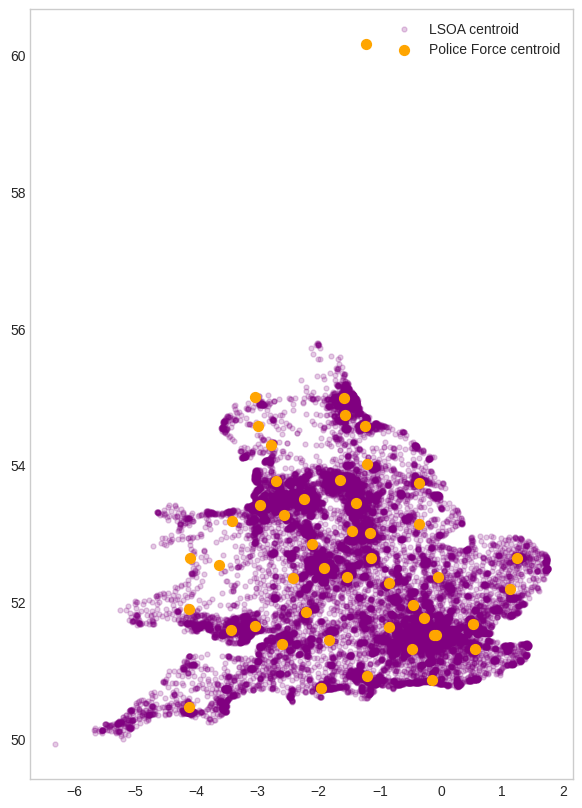

In [ ]:
#Calculate aggregated LSOA data with computed GPS centroids
#Just to display the next graph and sanity check
sql_query = '''
    SELECT
    LSOA_of_Accident_Location, COUNT(LSOA_of_Accident_Location) As Accident_Count,
    PERCENTILE(Latitude, 0.5) AS Centroid_Latitude,
    PERCENTILE(Longitude, 0.5) AS Centroid_Longitude
    FROM accidents
    GROUP BY LSOA_of_Accident_Location'''
lsoa_data = spark.sql(sql_query)
from matplotlib import pyplot as plt
df1 = lsoa_data.toPandas()
df2 = police_force_data.toPandas()
fig, ax = plt.subplots(figsize=(7,10))
ax.scatter(df1.Centroid_Longitude, df1.Centroid_Latitude, marker='.', alpha=0.2, s=50, c='purple', label='LSOA centroid')
ax.scatter(df2.Centroid_Longitude, df2.Centroid_Latitude, marker='.', alpha=1.0, s=200, c='orange', label='Police Force centroid')
l = ax.legend()
ax.grid(False)

lsoa_data.toPandas().head()

## Gradient Boosting Trees

In [ ]:
def load_and_split_summary_data(group=data_group, features=features):
    #load data and split into train/test rdds to be consumed by the gbt models
    start_time = time.time()
    rdd_data = load_data(group=group)
    #Split train/test
    rdd_train, rdd_test = rdd_data.randomSplit([0.8, 0.2], seed=rnd_seed)
    rdd_train = summarize_data_by_lsoa(rdd_train, feats = features['cat_pred'])
    rdd_test = summarize_data_by_lsoa(rdd_test, feats = features['cat_pred'])
    new_features={}
    new_features['response'] = 'Severity_Pct'
    new_features['cat_pred'] = features['cat_pred']
    print("loading completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return rdd_train, rdd_test, new_features


def create_and_train_gbt_model(features=features):
    #instantiate pipeline and train the model
    #categorical data is simply converted into indexes - the gbt models does not need one-hot encoding
    start_time = time.time()
    new_features = {}
    new_features['response'] = features['response']
    #string_encode categorical data using a list of indexers, one for each categorical data
    #ensureing the encoding is done on train+test set to have consistent encoding accross both sets
    rdd_data = rdd_train.unionAll(rdd_test)
    indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(rdd_data) for column in features['cat_pred']]
    new_features['cat_pred'] = [x+'_index' for x in features['cat_pred']]
    #Vectorise the inputs
    vectorAssembler = VectorAssembler(inputCols=new_features['cat_pred'], outputCol="features")
    #Instatiate classifier
    gbt = GBTRegressor(labelCol=new_features['response'], featuresCol="features",
                        maxIter=30, maxDepth=6, maxBins=100)
    #Create pipeline
    pipeline = Pipeline(stages=indexers + [vectorAssembler, gbt])
    #Fit Model
    model_gbt = pipeline.fit(rdd_train)
    print("training completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return new_features, pipeline, model_gbt


def evaluate_reg_model(model, rdd, set_name, response=features["response"]):
    #Calculate root mean squared error as a performance measures
    start_time = time.time()
    evaluator = RegressionEvaluator(labelCol=response, predictionCol="prediction", metricName="rmse")
    predY = model.transform(rdd)
    rmse = evaluator.evaluate(predY)
    print("Root Mean Squared Error (RMSE) on {} data = {:.2f}".format(set_name, rmse))
    print("evaluation completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return predY


def display_results_graphs(pred_train, pred_test):
    #Display the actual Sererity_Pct for each instance (sorted by increasing order) and compare to predictions
    #for both the train and test set
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    df1 = pred_train.toPandas().sort_values('Severity_Pct')
    df1.plot(y='Severity_Pct', ax=ax1, use_index=False, c='k', linewidth=2)
    df1.plot(y='prediction', ax=ax1, use_index=False, c='b', alpha=0.7)
    ax1.set_title("Train set", fontweight='bold')
    ax1.set_ylim(-.1, 1.2)
    ax1.set_xlabel("summary instance")
    ax1.set_ylabel("severity ratio")
    df2 = pred_test.toPandas().sort_values('Severity_Pct')
    df2.plot(y='Severity_Pct', ax=ax2, use_index=False, c='k', linewidth=2)
    df2.plot(y='prediction', ax=ax2, use_index=False,c='r', alpha=0.7)
    ax2.set_title("Test set", fontweight='bold')
    ax2.set_ylim(-.1, 1.2)
    ax2.set_xlabel("summary instance")
    ax2.set_ylabel("severity ratio")
    print("train set size={:d}, test set size={:d}".format(len(df1), len(df2)))
    return


def display_agg_results_graphs(pred_train, pred_test):
    #Display the actual Sererity_Pct for each instance (sorted by increasing order) and compare to predictions
    #for both the train and test set
    #But this time AGGREGATED by LSOA - this will be the actual deliverable
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    try:
        df1 = pred_train.toPandas().groupby(['LSOA_of_Accident_Location'])['Severity_Pct', 'prediction']\
                    .mean().reset_index().sort_values('Severity_Pct')
        df2 = pred_test.toPandas().groupby(['LSOA_of_Accident_Location'])['Severity_Pct', 'prediction']\
                    .mean().reset_index().sort_values('Severity_Pct')
    except:
        #normalised dataset
        df1 = pred_train.toPandas().groupby(['Centroid_Latitude','Centroid_Longitude'])['Severity_Pct', 'prediction']\
                    .mean().reset_index().sort_values('Severity_Pct')
        df2 = pred_test.toPandas().groupby(['Centroid_Latitude','Centroid_Longitude'])['Severity_Pct', 'prediction']\
                    .mean().reset_index().sort_values('Severity_Pct')
    bars = ax1.bar(range(len(df1)),df1.prediction, color='b', alpha=0.5, label='prediction')
    bars = ax1.bar(range(len(df1)),df1.Severity_Pct, color='none', edgecolor='k', lw=1, label='actual')
    ax1.xaxis.grid(False)
    ax1.set_xticks([])
    ax1.set_ylim(-.1, 1.2)
    ax1.set_xlabel("LSOA")
    ax1.set_ylabel("Avge severity ratio")
    ax1.set_title("Train set", fontweight='bold')
    l=ax1.legend()
    for bar in bars:
        bar.set_edgecolor("k")
        bar.set_linewidth(1)

    bars = ax2.bar(range(len(df2)),df2.prediction, color='r', alpha=0.5, label='prediction')
    bars = ax2.bar(range(len(df2)),df2.Severity_Pct, color='none', edgecolor='k', lw=1, label='actual')
    ax2.xaxis.grid(False)
    ax2.set_xticks([])
    ax2.set_ylim(-.1, 1.2)
    ax2.set_xlabel("LSOA")
    ax2.set_ylabel("Avge severity ratio")
    l=ax2.legend()
    ax2.set_title("Test set", fontweight='bold')
    for bar in bars:
        bar.set_edgecolor("k")
        bar.set_linewidth(1)
    return

Row(Accident_Severity='Slight', LSOA_of_Accident_Location='E01000004', Police_Force='City of London', Latitude=51.516575, Longitude=-0.08126, Weather_Conditions='Fine no high winds', Light_Conditions='Darkness - lights lit', Road_Surface_Conditions='Dry', Day_of_Week='Saturday', Hour=22, Week=53, Peak_or_OffPeak='OffPeak')
nb Slight:2000, nb Serious:328, %Slight: 85.9%
loading completed  - Processing time: 2 secs
training completed  - Processing time: 21 secs
Root Mean Squared Error (RMSE) on train data = 0.08
evaluation completed  - Processing time: 0 secs
Root Mean Squared Error (RMSE) on test data = 0.36
evaluation completed  - Processing time: 0 secs
train set size=292, test set size=112


<ipython-input-77-2d84fde7116c>:79: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df1 = pred_train.toPandas().groupby(['LSOA_of_Accident_Location'])['Severity_Pct', 'prediction']\
<ipython-input-77-2d84fde7116c>:81: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df2 = pred_test.toPandas().groupby(['LSOA_of_Accident_Location'])['Severity_Pct', 'prediction']\


DataFrame[Weather_Conditions: string, Light_Conditions: string, Road_Surface_Conditions: string, Day_of_Week: string, LSOA_of_Accident_Location: string, Peak_or_OffPeak: string, Slight: bigint, Serious: bigint, Severity_Pct: double]

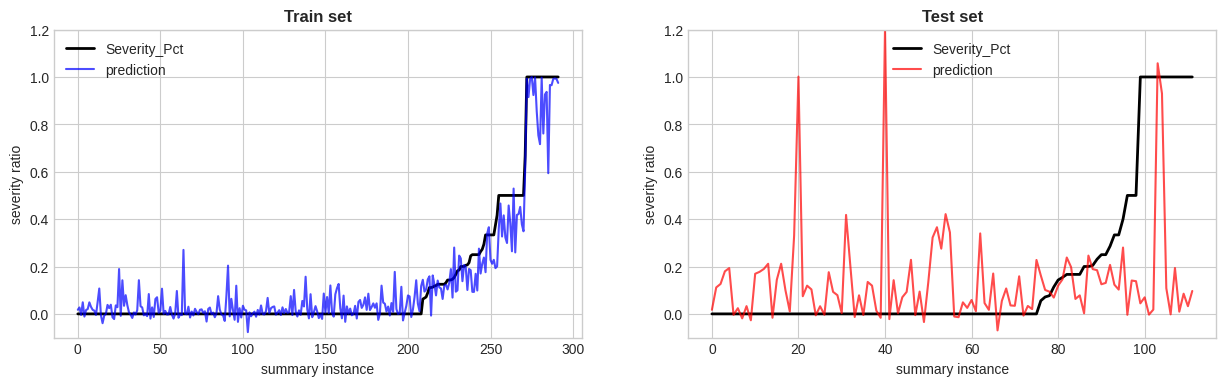

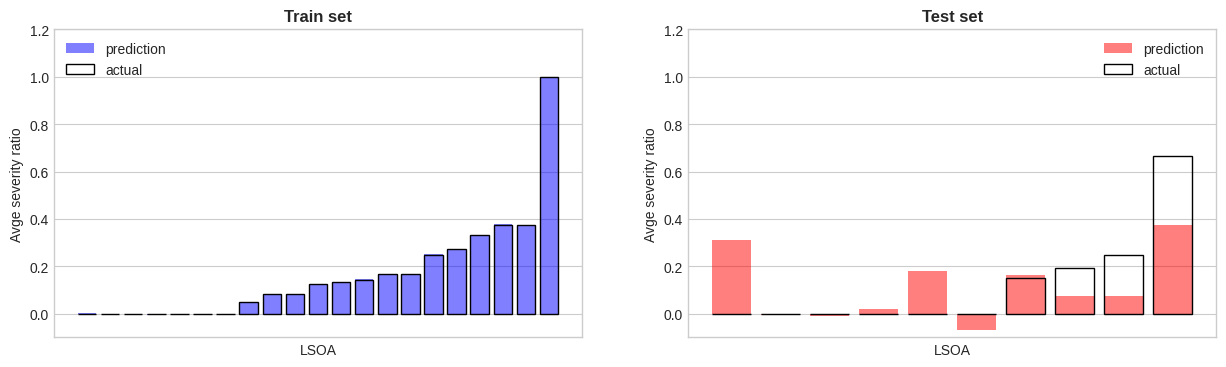

In [ ]:
features={
    'response':'Severity_Pct',
    'cat_pred': ['Weather_Conditions', 'Light_Conditions', 'Road_Surface_Conditions',\
            'Day_of_Week', 'LSOA_of_Accident_Location', 'Peak_or_OffPeak']}

data_group={
    'name': "Police_Force",
    'item': "City of London"}

rdd_train, rdd_test, ml_feats= load_and_split_summary_data(data_group, features)
rdd_train.cache()
rdd_test.cache()
ml_feats, pipeline, model_gbt = create_and_train_gbt_model(ml_feats)
pred_train = evaluate_reg_model(model_gbt, rdd_train, "train", response=ml_feats["response"])
pred_test = evaluate_reg_model(model_gbt, rdd_test, "test", response=ml_feats["response"])
display_results_graphs(pred_train, pred_test)
display_agg_results_graphs(pred_train, pred_test)
rdd_train.unpersist()
rdd_test.unpersist()

The average proportion of accident severity across all the LSOAs is around 15%
On this dataset it appears that instances are quite binary: most ratios are either 0 or 1, with little in-between
Aggreated at LSOA level the results are smoother bold text bold text

In [ ]:
def one_hot_encode(rdd_data, columns):
    #one_hot_encode categorical variables
    for column in columns:
        try:
            rdd_data = OneHotEncoder(inputCol=column, outputCol=column+"_vec").transform(rdd_data)
        except:
            print("One_hot encoding already performed for ", column)
    columns_vec = [x+'_vec' for x in columns]
    return rdd_data, columns_vec


def one_hot_encode_new(rdd_data, columns):
    # Create a list to store the OneHotEncoder instances
    encoder_list = []

    # Iterate through columns to create and apply OneHotEncoder
    for column in columns:
        try:
            encoder = OneHotEncoder(inputCol=column, outputCol=column+"_vec")
            encoder_list.append(encoder)
        except:
            print("One-hot encoding already performed for ", column)

    # Create a pipeline to execute the encoders
    pipeline = Pipeline(stages=encoder_list)

    # Fit and transform the data using the pipeline
    rdd_data = pipeline.fit(rdd_data).transform(rdd_data)

    # Create a list of the new feature names
    columns_vec = [f'{x}_vec' for x in columns]

    return rdd_data, columns_vec


def load_one_hot_and_split_data_with_centroids(group=data_group, features=features):
    #Because of the vectorisation of features required by spark ML,
    #we have to either normalise all features or none
    #This means that we now have to explicitly one-hot encode the categorical features
    #The encoding has to be done before the train/test split to ensure that it is consistent across both sets
    #The fianl step is aggregating the data by lsoa and compute our response feature
    start_time = time.time()
    rdd_data = load_data(group=group)
    new_features={}
    new_features['response'] = 'Severity_Pct'
    new_features['cat_pred'] = features['cat_pred']
    #Add centroid data
    sql_query = '''
        SELECT
        LSOA_of_Accident_Location, COUNT(LSOA_of_Accident_Location) As Accident_Count,
        PERCENTILE(Latitude, 0.5) AS Centroid_Latitude,
        PERCENTILE(Longitude, 0.5) AS Centroid_Longitude
        FROM accidents
        GROUP BY LSOA_of_Accident_Location'''
    lsoa_data = spark.sql(sql_query)
    rdd_data = rdd_data.join(lsoa_data, rdd_data.LSOA_of_Accident_Location == lsoa_data.LSOA_of_Accident_Location)\
    .drop(lsoa_data.LSOA_of_Accident_Location).drop(lsoa_data.Accident_Count)
    #remove null values
    #rdd_data = rdd_data.select([to_null(c).alias(c) for c in rdd_data.columns]).na.drop()
    #add centroids in feature list
    new_features['ord_pred'] = ['Centroid_Latitude', 'Centroid_Longitude']
    #remove LSOA_of_Accident_Location from feature list
    if 'LSOA_of_Accident_Location' in new_features['cat_pred']: new_features['cat_pred'].remove('LSOA_of_Accident_Location')
    #one_one encode categorical data
    rdd_data, new_features['cat_pred'] = string_encode(rdd_data, new_features['cat_pred'])
    rdd_data, new_features['cat_pred_vec'] = one_hot_encode_new(rdd_data, new_features['cat_pred'])
    #Split train/test
    rdd_train, rdd_test = rdd_data.randomSplit([0.8, 0.2], seed=rnd_seed)
    rdd_train = summarize_data_by_lsoa(rdd_train, feats = new_features['cat_pred_vec']+new_features['ord_pred'])
    rdd_test = summarize_data_by_lsoa(rdd_test, feats = new_features['cat_pred_vec']+new_features['ord_pred'])
    print("loading completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return rdd_train, rdd_test, new_features



def create_and_train_gbt_model_normalised(rdd_train, features=features):
    #instantiate pipeline and train the model
    start_time = time.time()
    new_features = features
    #Vectorise the inputs
    vectorAssembler = VectorAssembler(inputCols=new_features['cat_pred_vec']+new_features['ord_pred'], outputCol="features")
    #Normalise all features
    scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
    #Instatiate classifier
    gbt = GBTRegressor(labelCol=new_features['response'], featuresCol="scaledFeatures",
                        maxIter=30, maxDepth=6, maxBins=100)
    #Create pipeline
    pipeline = Pipeline(stages=[vectorAssembler, scaler, gbt])
    #Fit Model
    model_gbt = pipeline.fit(rdd_train)
    print("training completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return pipeline, model_gbt


Row(Accident_Severity='Slight', LSOA_of_Accident_Location='E01000004', Police_Force='City of London', Latitude=51.516575, Longitude=-0.08126, Weather_Conditions='Fine no high winds', Light_Conditions='Darkness - lights lit', Road_Surface_Conditions='Dry', Day_of_Week='Saturday', Hour=22, Week=53, Peak_or_OffPeak='OffPeak')
nb Slight:2000, nb Serious:328, %Slight: 85.9%
Standard NA.drop only
Standard NA.drop only
loading completed  - Processing time: 16 secs
training completed  - Processing time: 28 secs
Root Mean Squared Error (RMSE) on train data = 0.09
evaluation completed  - Processing time: 0 secs
Root Mean Squared Error (RMSE) on test data = 0.33
evaluation completed  - Processing time: 9 secs
train set size=292, test set size=112


<ipython-input-77-2d84fde7116c>:85: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df1 = pred_train.toPandas().groupby(['Centroid_Latitude','Centroid_Longitude'])['Severity_Pct', 'prediction']\
<ipython-input-77-2d84fde7116c>:87: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df2 = pred_test.toPandas().groupby(['Centroid_Latitude','Centroid_Longitude'])['Severity_Pct', 'prediction']\


DataFrame[Weather_Conditions_index_vec: vector, Light_Conditions_index_vec: vector, Road_Surface_Conditions_index_vec: vector, Day_of_Week_index_vec: vector, Peak_or_OffPeak_index_vec: vector, Centroid_Latitude: double, Centroid_Longitude: double, Slight: bigint, Serious: bigint, Severity_Pct: double]

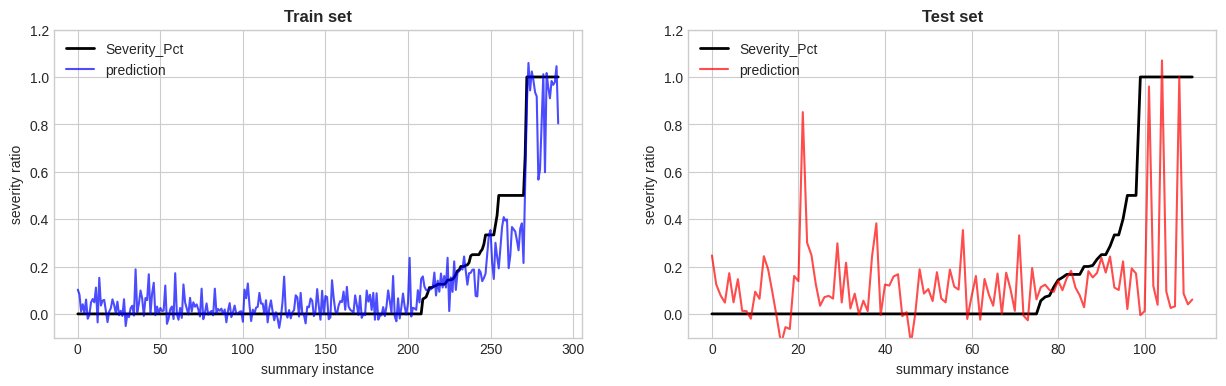

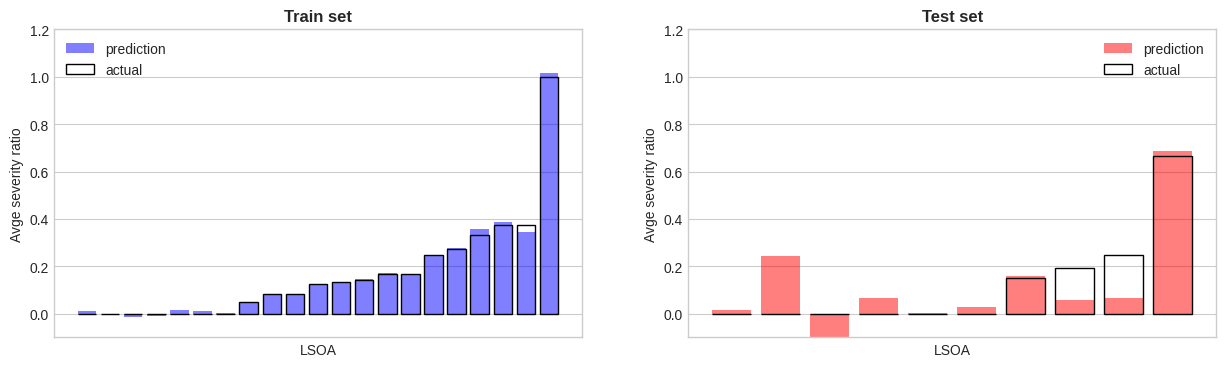

In [ ]:
features={
    'response':'Severity_Pct',
    'cat_pred': ['Weather_Conditions', 'Light_Conditions', 'Road_Surface_Conditions',\
            'Day_of_Week', 'LSOA_of_Accident_Location', 'Peak_or_OffPeak'],\
    'ord_pred':['Centroid_Latitude', 'Centroid_Longitude']}

data_group={
    'name': "Police_Force",
    'item': "City of London"}

rdd_train_norm, rdd_test_norm, ml_feats= load_one_hot_and_split_data_with_centroids(data_group, features)
rdd_train_norm.cache()
rdd_test_norm.cache()
pipeline_norm, model_gbt_norm = create_and_train_gbt_model_normalised(rdd_train_norm, ml_feats)
pred_train_norm = evaluate_reg_model(model_gbt_norm, rdd_train_norm, "train", response=ml_feats["response"])
pred_test_norm = evaluate_reg_model(model_gbt_norm, rdd_test_norm, "test", response=ml_feats["response"])
display_results_graphs(pred_train_norm, pred_test_norm)
display_agg_results_graphs(pred_train_norm, pred_test_norm)
rdd_train_norm.unpersist()
rdd_test_norm.unpersist()

Using LSOA centroids GPS data as ordinal feature instead of LSOA designation as a categorical feature improves performance.
Let's use a cross-validated grid search to see if we can improve further

### Grid Search

In [ ]:
def run_grid_search(rdd_data, pipeline, response=features["response"], maxDepth=[4, 6, 10], maxBins=[60, 100], maxIter=[40, 60]):
    gbt = pipeline.getStages()[-1]
    paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, maxDepth)
             .addGrid(gbt.maxBins, maxBins)
             .addGrid(gbt.maxIter, maxIter)
             .build())
    evaluator = RegressionEvaluator(labelCol=response, predictionCol="prediction", metricName="rmse")
    cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
    start_time = time.time()
    cvModel = cv.fit(rdd_data)
    print("Grid search completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return cvModel


def get_best_model(cvModel):
    return cvModel.bestModel


def get_best_model_params(cvModel):
    best_gbt_params = {"MaxDepth": cvModel.bestModel.stages[-1]._java_obj.getMaxDepth(),
    "maxBins": cvModel.bestModel.stages[-1]._java_obj.getMaxBins(),
    "maxIter": cvModel.bestModel.stages[-1]._java_obj.getMaxIter()}
    print("Best GBT parameters found: {}".format(best_gbt_params))
    return best_gbt_params

In [ ]:
#Run grid search with standard evaluator
rdd_train_norm.cache()
cvModel_norm = run_grid_search(rdd_train_norm, pipeline_norm, response=ml_feats["response"],
                                      maxDepth=[4, 6], maxBins=[50, 100], maxIter=[40])

Grid search completed  - Processing time: 370 secs


Best model metrics:
Best GBT parameters found: {'MaxDepth': 4, 'maxBins': 50, 'maxIter': 40}
Root Mean Squared Error (RMSE) on train data = 0.17
evaluation completed  - Processing time: 0 secs
Root Mean Squared Error (RMSE) on test data = 0.31
evaluation completed  - Processing time: 7 secs
train set size=292, test set size=112


<ipython-input-77-2d84fde7116c>:85: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df1 = pred_train.toPandas().groupby(['Centroid_Latitude','Centroid_Longitude'])['Severity_Pct', 'prediction']\
<ipython-input-77-2d84fde7116c>:87: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df2 = pred_test.toPandas().groupby(['Centroid_Latitude','Centroid_Longitude'])['Severity_Pct', 'prediction']\


DataFrame[Weather_Conditions_index_vec: vector, Light_Conditions_index_vec: vector, Road_Surface_Conditions_index_vec: vector, Day_of_Week_index_vec: vector, Peak_or_OffPeak_index_vec: vector, Centroid_Latitude: double, Centroid_Longitude: double, Slight: bigint, Serious: bigint, Severity_Pct: double]

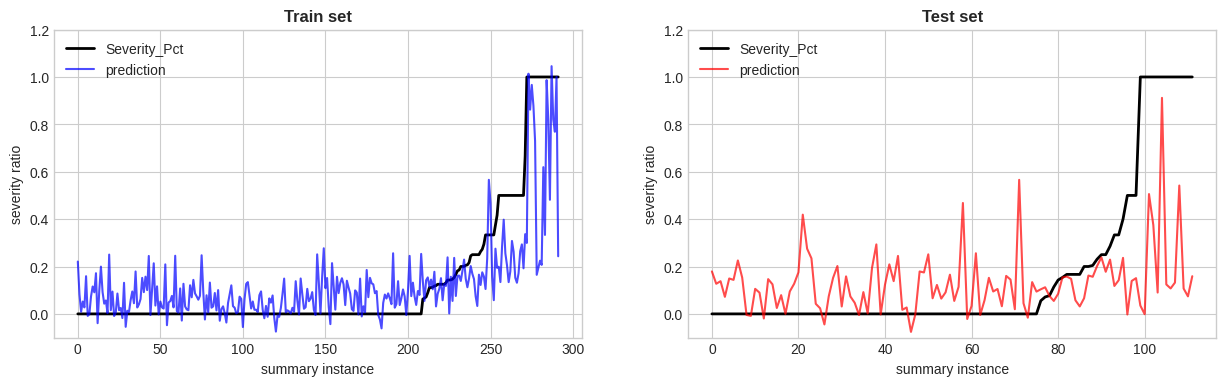

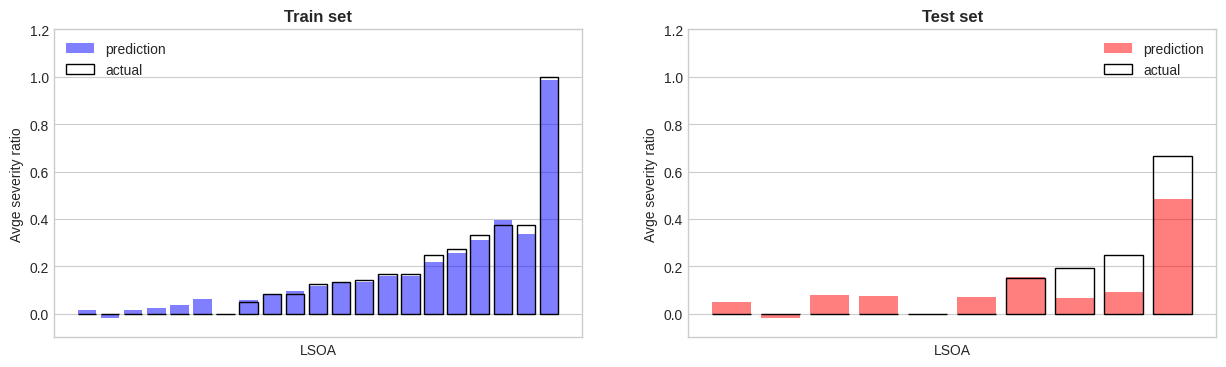

In [ ]:
print("Best model metrics:")
best_gbt = get_best_model(cvModel_norm)
best_gbt_params = get_best_model_params(cvModel_norm)
rdd_test_norm.cache()
pred_train_norm = evaluate_reg_model(best_gbt, rdd_train_norm, "train", response=ml_feats["response"])
pred_test_norm = evaluate_reg_model(best_gbt, rdd_test_norm, "test", response=ml_feats["response"])
display_results_graphs(pred_train_norm, pred_test_norm)
display_agg_results_graphs(pred_train_norm, pred_test_norm)
rdd_train_norm.unpersist()
rdd_test_norm.unpersist()

In [ ]:
# Assuming 'best_gbt' is the best GBT model
best_gbt.save("/content/drive/MyDrive/651 Project/model")

# Deep Neural Network

In [ ]:
!pip install keras==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.14.0 requires keras<2.15,>=2.14.0, but you have keras 2.12.0 which is incompatible.


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import Callback
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import MinMaxScaler as MinMax
from keras.utils import np_utils

In [ ]:
#repeat some global variables

features={
    'response':'Severity_Pct',
    'cat_pred': ['Weather_Conditions', 'Light_Conditions', 'Road_Surface_Conditions',\
            'Day_of_Week', 'LSOA_of_Accident_Location', 'Peak_or_OffPeak']}
data_group={
    'name': "Police_Force",
    'item': "City of London"}

response='Severity_Pct'


def local_load_one_hot_and_split_data(group=data_group, features=features, centroids=False):
    #main data transformation function for the deep models:
    #Generate train and test sets as Pandas dataframes
    #because we are running Keras locally and not on the distributed Spark cluster.
    #The aggregation procedure is adapted accordingly
    #Centroids features are added or not to test their impacts on performance
    #The main difficulty here is to perform all the required transformations (scaling, encoding) on the full
    #dataset, then split into train/test then finally summarize as the last step
    #This is to ensure that the data is encoded consistently between the two sets
    start_time = time.time()
    rdd_data = load_data(group=group)
    new_features={}
    new_features['response'] = 'Severity_Pct'
    new_features['cat_pred'] = features['cat_pred']
    #separate lsoa vs centroids
    if centroids:
        sql_query = '''
            SELECT
            LSOA_of_Accident_Location, COUNT(LSOA_of_Accident_Location) As Accident_Count,
            PERCENTILE(Latitude, 0.5) AS Centroid_Latitude,
            PERCENTILE(Longitude, 0.5) AS Centroid_Longitude
            FROM accidents
            GROUP BY LSOA_of_Accident_Location'''
        lsoa_data = spark.sql(sql_query)
        rdd_data = rdd_data.join(lsoa_data, rdd_data.LSOA_of_Accident_Location == lsoa_data.LSOA_of_Accident_Location)\
        .drop(lsoa_data.LSOA_of_Accident_Location).drop(lsoa_data.Accident_Count)
        #remove null values
        rdd_data = rdd_data.select([to_null(c).alias(c) for c in rdd_data.columns]).na.drop()
        #add centroids in feature list
        new_features['ord_pred'] = ['Centroid_Latitude', 'Centroid_Longitude']
    else:
        new_features['ord_pred']=[]
    dataset = rdd_data.toPandas()
    if centroids:
        #scale lat/lon data into [0,1]
        scaler = MinMax()
        columns = ['Centroid_Latitude', 'Centroid_Longitude']
        dataset[columns] = scaler.fit_transform(dataset[columns])
    #one_hot encode categorical data
    #list all possible lsoas in dataset
    lsoa_cat = list(set(dataset['LSOA_of_Accident_Location'].values))
    #remove LSOA_of_Accident_Location from feature list before performing get_dummies
    if 'LSOA_of_Accident_Location' in new_features['cat_pred']:
        new_features['cat_pred'].remove('LSOA_of_Accident_Location')
    dataset = pd.get_dummies(dataset, columns=new_features['cat_pred']+['Accident_Severity'])
    #split before summarising - how to ensure that one hot encoding of lsoa is consistent????
    data_train, data_test = train_test_split(dataset, test_size=0.2, random_state=rnd_seed)
    data_train = summarize_dataset_by_lsoa(data_train, lsoa_cat, centroids)
    data_test = summarize_dataset_by_lsoa(data_test, lsoa_cat, centroids)
    assert (data_train.columns==data_test.columns).all()
    all_pred = [x for x in data_train.columns if x != 'Severity_Pct']
    print("loading completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return data_train, data_test, all_pred



def summarize_dataset_by_lsoa(dataset, lsoa_cat, centroids):
    #summarize adapted to Pandas get_dummies: we explicitely specifiy the encoding form LSOAs
    #so that the encoding is the same on train and test set
    dummy_severity =['Accident_Severity_Serious','Accident_Severity_Slight']
    to_remove = ['Accident_Severity', 'Police_Force', 'Latitude','Longitude','Hour','Week'] + dummy_severity
    to_remove = to_remove + (['LSOA_of_Accident_Location'] if centroids else [])
    features_kept = [x for x in list(dataset.columns.values) if x not in to_remove]
    df = dataset.groupby(features_kept)[dummy_severity].apply(lambda x : x.astype(int).sum()).reset_index()
    df['Severity_Pct'] = df['Accident_Severity_Serious']/(df['Accident_Severity_Serious']+df['Accident_Severity_Slight'])
    df = df.drop(dummy_severity, axis=1)
    if 'LSOA_of_Accident_Location' in df.columns:
        #cast lsoa column as categorical - this ensures that get_dummies will be consistent when applied after train/test split
        if lsoa_cat is not None:
          df['LSOA_of_Accident_Location'] = pd.Categorical(df['LSOA_of_Accident_Location'], categories=lsoa_cat)
        df = pd.get_dummies(df, columns=['LSOA_of_Accident_Location'])
    return df



def display_local_results_graphs(df1, df2):
    #same as the GBT model
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    df1 = df1.sort_values('Severity_Pct')
    df1.plot(y='Severity_Pct', ax=ax1, use_index=False, c='k', linewidth=2)
    df1.plot(y='prediction', ax=ax1, use_index=False, c='b', alpha=0.7)
    ax1.set_title("Train set", fontweight='bold')
    ax1.set_ylim(-.1, 1.2)
    ax1.set_xlabel("summary instance")
    ax1.set_ylabel("severity ratio")
    df2 = df2.sort_values('Severity_Pct')
    df2.plot(y='Severity_Pct', ax=ax2, use_index=False, c='k', linewidth=2)
    df2.plot(y='prediction', ax=ax2, use_index=False,c='r', alpha=0.7)
    ax2.set_title("Test set", fontweight='bold')
    ax2.set_ylim(-.1, 1.2)
    ax2.set_xlabel("summary instance")
    ax2.set_ylabel("severity ratio")
    print("train set size={:d}, test set size={:d}".format(len(df1), len(df2)))
    return

In [ ]:
import tensorflow as tf
from keras import backend as K
from keras.callbacks import Callback


# create model
def create_small_nn_model():
    model = Sequential()
    model.add(Dense(32, input_dim=len(all_pred), kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    print(model.summary())
    return model


def create_large_nn_model():
    model = Sequential()
    model.add(Dense(128, input_dim=len(all_pred), kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    print(model.summary())
    return model

def root_mean_squared_error(y_true, y_pred):
    #custom rmse measure for history plots
        return K.sqrt(K.mean(K.square(y_pred - y_true)))



class LossHistory(Callback):
    #used to store train and val losses during trainnig for display later
    def on_train_begin(self, logs={}):
        self.counter = 0
        self.losses = []
        #self.train_loss = []
        self.val_loss = []

    def on_train_end(self, logs={}):
        print()
        return
    def on_epoch_end(self, batch, logs={}):
        self.counter += 1
        self.losses.append(logs.get('loss'))
        y_pred = self.model.predict(self.validation_data[0])
        val_loss = root_mean_squared_error(self.validation_data[1], y_pred)
        self.val_loss.append(K.eval(val_loss))
        sys.stdout.write('\r epoch:{:d}, current loss={:0.3f}, val_loss={:0.3f}'.\
                         format(self.counter, logs.get('loss'),K.eval(val_loss)))
        sys.stdout.flush()


def nn_model_compile_and_train(model, X_train, Y_train, batch_size=128, epochs=300):
    # Compile model, train and display learning curves
    start_time = time.time()
    lr = LossHistory()
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[root_mean_squared_error])
    history = model.fit(X_train, Y_train,  epochs=epochs, batch_size=batch_size, validation_split = 0.2,
                        verbose=2, shuffle=True)
    print("Training time: {:0.0f} secs".format(time.time() - start_time))
    # list all data in history
    plot_learning_curves(history)
    return model, lr


def plot_learning_curves(history):
    # summarize history
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    ax1.plot([np.sqrt(x) for x in history.history['loss']], alpha=0.8, linewidth=4, c='b')
    ax1.plot([np.sqrt(x) for x in history.history['val_loss']], alpha=0.8, linewidth=4, c='r')
    ax1.set_title('model RMSE')
    ax1.set_ylabel('rmse')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'val'], loc='upper left')
    return



def evaluate_nn_model(model, dataset, set_name):
    #Calculate rmse performance measure
    start_time = time.time()
    X = dataset[all_pred].values
    Y = dataset[response].values
    predY  = model.predict(X)
    dataset['prediction'] = predY
    rmse = np.sqrt(mean_squared_error(Y, predY))
    print("Root Mean Squared Error (RMSE) on {} data = {:.2f}".format(set_name, rmse))
    print("evaluation completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return dataset, predY


In [ ]:
data_train, data_test, all_pred = local_load_one_hot_and_split_data(group=data_group, features=features, centroids=False)

Row(Accident_Severity='Slight', LSOA_of_Accident_Location='E01000004', Police_Force='City of London', Latitude=51.516575, Longitude=-0.08126, Weather_Conditions='Fine no high winds', Light_Conditions='Darkness - lights lit', Road_Surface_Conditions='Dry', Day_of_Week='Saturday', Hour=22, Week=53, Peak_or_OffPeak='OffPeak')
nb Slight:2000, nb Serious:328, %Slight: 85.9%
loading completed  - Processing time: 6 secs


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1440      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 4)                 3

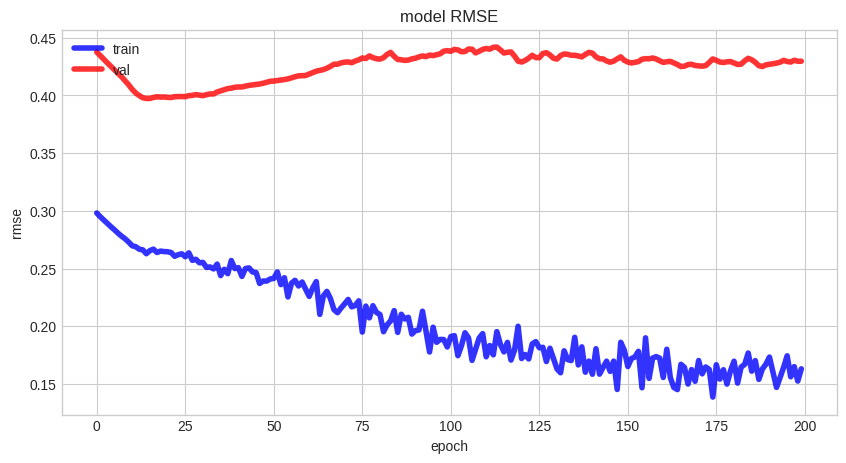

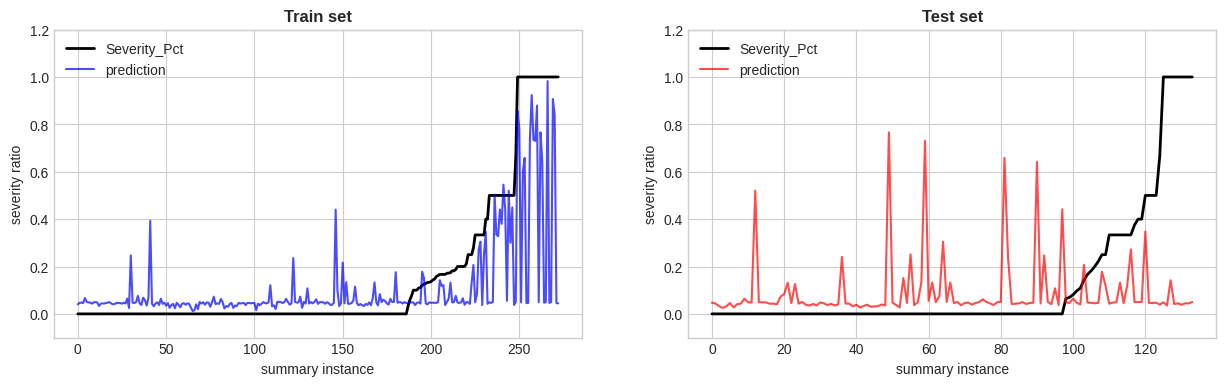

In [ ]:
small_nn_model = create_small_nn_model()
small_nn_model ,lr = nn_model_compile_and_train(small_nn_model,
                data_train[all_pred].values, data_train[response], batch_size=32, epochs=200)
data_train, nn_pred_train = evaluate_nn_model(small_nn_model, data_train,  "train")
data_test, nn_pred_test = evaluate_nn_model(small_nn_model, data_test, "test")
display_local_results_graphs(data_train, data_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               5760      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 16)               

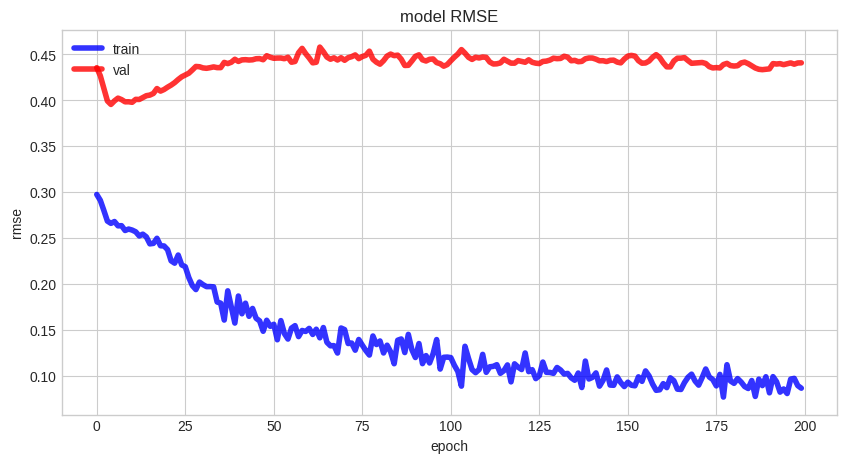

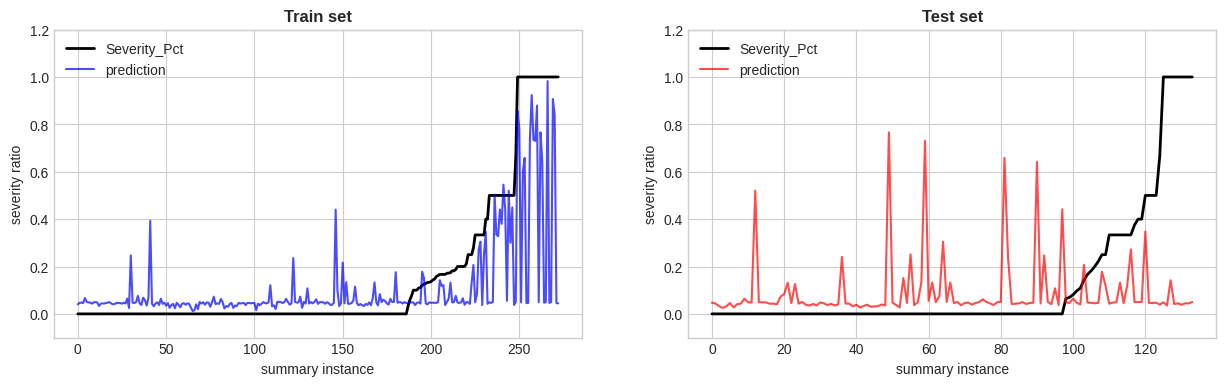

In [ ]:
large_nn_model = create_large_nn_model()
large_nn_model ,lr = nn_model_compile_and_train(large_nn_model,
                data_train[all_pred].values, data_train[response], batch_size=32, epochs=200)
data_train, nn_pred_train = evaluate_nn_model(small_nn_model, data_train,  "train")
data_test, nn_pred_test = evaluate_nn_model(small_nn_model, data_test, "test")
display_local_results_graphs(data_train, data_test)